# Infilling COVID recovery data
First, we must clean the data. Several columns are not GHGs so we remove them. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pyam
import silicone.utils
import silicone.database_crunchers as dc
import silicone.multiple_infillers as mi

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
input = pd.read_excel("../input/CompiledPiersScenarios_distri_with_cleaning.xlsx", header=[0, 1])
sr15_data = silicone.utils.download_or_load_sr15("../input/complete_sr15.csv")
use_ar4_data = True
lead = "Emissions|Kyoto Gases (AR4-GWP100)"
convert_n2o = (2 * 14 + 16) / (2 * 14) 
convert_co2 = (12 + 2 * 16) / 12
input

pyam.utils - INFO: Reading `../input/complete_sr15.csv`


,model,scenario,year,co2_fossil,co2_land,ch4,n2o,sox,co,nmvoc,...,mcf,hcfc22,hcfc141b,hcfc142b,halon1211,halon1202,halon1301,halon2402,ch3br,ch3cl
,Unnamed: 0_level_1,Unnamed: 1_level_1,Unnamed: 2_level_1,GtC/yr,GtC/yr,Mt/yr,Mt/yr [units of N],Mt/yr [units of S],Mt/yr,Mt/yr,...,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr
0,emissions_ndc_month_base,Baseline,2020,9.401228,1.384467,324.937346,6.081999,35.540802,756.389584,167.700559,...,0,444.821,57.463,18.867,2.531,0,0.911,0.055,155.925,3511.082
1,emissions_ndc_month_base,Baseline,2030,10.406026,0.858738,338.217710,6.750341,34.062300,721.864751,161.375566,...,0,472.764,58.080,9.424,1.225,0,0.545,0.017,155.925,3511.082
2,emissions_ndc_month_base,Baseline,2040,11.224362,0.211322,316.024645,6.862659,28.229820,652.913333,149.261614,...,0,240.141,44.431,4.563,0.593,0,0.326,0.005,155.925,3511.082
3,emissions_ndc_month_g1_3,Green-recovery,2020,9.401228,1.384467,324.937346,6.081999,35.540802,756.389584,167.700559,...,0,444.821,57.463,18.867,2.531,0,0.911,0.055,155.925,3511.082
4,emissions_ndc_month_g1_3,Green-recovery,2030,6.671190,0.553782,217.080547,4.330161,21.865040,463.442623,103.611824,...,0,472.764,58.080,9.424,1.225,0,0.545,0.017,155.925,3511.082
5,emissions_ndc_month_g2_2,Fossil-recovery,2020,9.401228,1.384467,324.937346,6.081999,35.540802,756.389584,167.700559,...,0,444.821,57.463,18.867,2.531,0,0.911,0.055,155.925,3511.082
6,emissions_ndc_month_g2_2,Fossil-recovery,2030,11.446629,0.944612,372.039481,7.425375,37.468530,794.051226,177.513122,...,0,472.764,58.080,9.424,1.225,0,0.545,0.017,155.925,3511.082
7,emissions_ndc_month_g2_2,Fossil-recovery,2040,12.346798,0.232455,347.627110,7.548925,31.052802,718.204666,164.187775,...,0,240.141,44.431,4.563,0.593,0,0.326,0.005,155.925,3511.082


We need to reshape this into the correct structure for pyam

In [3]:
input = input.set_index(keys=[input.columns[0], input.columns[1], input.columns[2]])

In [4]:
input = input.stack(level=[0, 1]).reset_index()
input

,"(model, Unnamed: 0_level_1)","(scenario, Unnamed: 1_level_1)","(year, Unnamed: 2_level_1)",level_3,level_4,0
0,emissions_ndc_month_base,Baseline,2020,bc,Mt/yr,5.768693
1,emissions_ndc_month_base,Baseline,2020,c2f6,kt/yr,1.557000
2,emissions_ndc_month_base,Baseline,2020,c6f14,kt/yr,0.347200
3,emissions_ndc_month_base,Baseline,2020,carb_tet,kt/yr,0.000000
4,emissions_ndc_month_base,Baseline,2020,cf4,kt/yr,10.949979
...,...,...,...,...,...,...
307,emissions_ndc_month_g2_2,Fossil-recovery,2040,nmvoc,Mt/yr,164.187775
308,emissions_ndc_month_g2_2,Fossil-recovery,2040,nox,Mt/yr [units of N],36.895177
309,emissions_ndc_month_g2_2,Fossil-recovery,2040,oc,Mt/yr,25.661602
310,emissions_ndc_month_g2_2,Fossil-recovery,2040,sf6,kt/yr,2.960982


In [5]:
input = input.rename(
    {
        input.columns[0]: "model", 
        input.columns[1]: "scenario", 
        input.columns[2]: "year", 
        input.columns[3]: "variable",
        input.columns[4]: "unit", 
        input.columns[5]: "value"
    }, 
    axis= 1)
input["region"] = "World"

In [6]:
input_df = pyam.IamDataFrame(input)
unwanted_cols = ["sox", "co", "nmvoc", "nox", "bc", "oc", "nh3", "cfc113", "carb_tet", "cfc114", "mcf", "halon1202"]
input_df.filter(variable=unwanted_cols, keep=False, inplace=True)
input_df.data.head(30)

,model,scenario,region,variable,unit,year,value
3,emissions_ndc_month_base,Baseline,World,c2f6,kt/yr,2020,1.557000
4,emissions_ndc_month_base,Baseline,World,c2f6,kt/yr,2030,1.549600
5,emissions_ndc_month_base,Baseline,World,c2f6,kt/yr,2040,1.465300
6,emissions_ndc_month_base,Baseline,World,c6f14,kt/yr,2020,0.347200
7,emissions_ndc_month_base,Baseline,World,c6f14,kt/yr,2030,0.345400
8,emissions_ndc_month_base,Baseline,World,c6f14,kt/yr,2040,0.326700
12,emissions_ndc_month_base,Baseline,World,cf4,kt/yr,2020,10.949979
13,emissions_ndc_month_base,Baseline,World,cf4,kt/yr,2030,9.483124
14,emissions_ndc_month_base,Baseline,World,cf4,kt/yr,2040,10.591102
15,emissions_ndc_month_base,Baseline,World,cfc11,kt/yr,2020,30.725000


Convert units. We need to change the format of the unit names first so they are recognised by pyam. 

In [7]:
input_df.convert_unit("Mt/yr [units of N]", "Mt/yr", convert_n2o, inplace=True)
input_df.convert_unit("GtC/yr", "GtCO2/yr", convert_co2, inplace=True)

In [8]:
orig_units = input_df.variables(True)
unit_rename_dict = {
    orig_units["variable"].iloc[i]: orig_units["unit"].iloc[i][:2] + " " + 
    orig_units["variable"].iloc[i].upper().replace("_FOSSIL", "").replace("_LAND", "").replace("HFC43_10", "HFC4310mee") + "/yr" for i in range(len(orig_units))
}

In [9]:
for i in input_df.data.index:
    input_df.data.loc[i, "unit"] = unit_rename_dict[input_df.data.loc[i, "variable"]]

In [10]:
input_df.data

,model,scenario,region,variable,unit,year,value
3,emissions_ndc_month_base,Baseline,World,c2f6,kt C2F6/yr,2020,1.557000
4,emissions_ndc_month_base,Baseline,World,c2f6,kt C2F6/yr,2030,1.549600
5,emissions_ndc_month_base,Baseline,World,c2f6,kt C2F6/yr,2040,1.465300
6,emissions_ndc_month_base,Baseline,World,c6f14,kt C6F14/yr,2020,0.347200
7,emissions_ndc_month_base,Baseline,World,c6f14,kt C6F14/yr,2030,0.345400
...,...,...,...,...,...,...,...
292,emissions_ndc_month_g2_2,Fossil-recovery,World,n2o,Mt N2O/yr,2030,11.668446
293,emissions_ndc_month_g2_2,Fossil-recovery,World,n2o,Mt N2O/yr,2040,11.862597
306,emissions_ndc_month_g2_2,Fossil-recovery,World,sf6,kt SF6/yr,2020,6.318104
307,emissions_ndc_month_g2_2,Fossil-recovery,World,sf6,kt SF6/yr,2030,6.659998


In [11]:
converted_input = silicone.utils.convert_units_to_MtCO2_equiv(input_df, use_ar4_data=use_ar4_data)

pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated an

In [12]:
converted_input.filter(year=2020, scenario="Baseline").data.head(10)

,model,scenario,region,variable,unit,year,value
3,emissions_ndc_month_base,Baseline,World,c2f6,Mt CO2-equiv/yr,2020,18.995400
6,emissions_ndc_month_base,Baseline,World,c6f14,Mt CO2-equiv/yr,2020,3.228960
12,emissions_ndc_month_base,Baseline,World,cf4,Mt CO2-equiv/yr,2020,80.920345
15,emissions_ndc_month_base,Baseline,World,cfc11,Mt CO2-equiv/yr,2020,145.943750
24,emissions_ndc_month_base,Baseline,World,cfc115,Mt CO2-equiv/yr,2020,0.073700
27,emissions_ndc_month_base,Baseline,World,cfc12,Mt CO2-equiv/yr,2020,165.472900
30,emissions_ndc_month_base,Baseline,World,ch3br,Mt CO2-equiv/yr,2020,0.779625
33,emissions_ndc_month_base,Baseline,World,ch3cl,Mt CO2-equiv/yr,2020,45.644066
36,emissions_ndc_month_base,Baseline,World,ch4,Mt CO2-equiv/yr,2020,8123.433662
42,emissions_ndc_month_base,Baseline,World,co2_fossil,Mt CO2-equiv/yr,2020,34471.170642


# Infilling the consistent units
We now need to construct a Kyoto total for this and can then split this into the relevant components. 

In [13]:
kyoto_input = silicone.utils._construct_consistent_values(
    lead, converted_input.variables().to_list(), converted_input
)
kyoto_gases = ["Emissions|CO2", "Emissions|N2O", "Emissions|F-Gases", "Emissions|CH4"]

In [14]:
kyoto_input.data.head()

,model,scenario,region,variable,unit,year,value
0,emissions_ndc_month_base,Baseline,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2020,53401.289837
1,emissions_ndc_month_base,Baseline,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2030,55829.023463
2,emissions_ndc_month_base,Baseline,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2040,55237.518534
3,emissions_ndc_month_g1_3,Green-recovery,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2020,53401.289837
4,emissions_ndc_month_g1_3,Green-recovery,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2030,36854.688867


In [15]:
# Infill the desired components using interpolation between the nearest MESSAGE-GLOBIOM SSP2 scenarios
infiller_df = sr15_data.filter(model="MESSAGE-GLOBIOM*", scenario="SSP2*")

In [16]:
# We also need to check that the calculated Kyoto totals agrees with the reported values in the database. 
corrected_infiller_df = silicone.utils._construct_consistent_values(
    lead, kyoto_gases, silicone.utils.convert_units_to_MtCO2_equiv(
        infiller_df.filter(variable=kyoto_gases), use_ar4_data=use_ar4_data
    )
)

pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!


pyam.plotting - INFO: >=13 labels, not applying legend


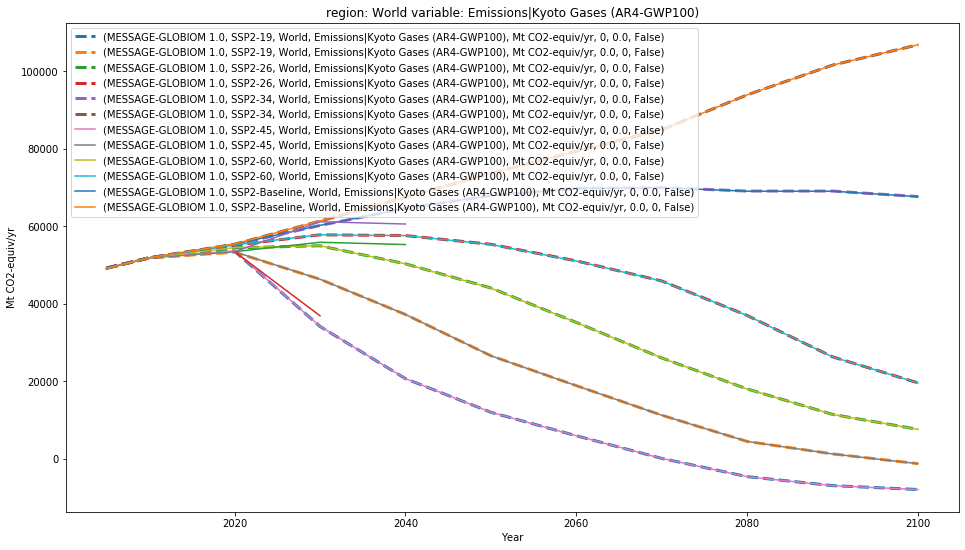

In [17]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
corrected_infiller_df.line_plot(ax=ax, linestyle="--", linewidth = 3)
infiller_df.filter(variable=lead).line_plot(ax=ax)
kyoto_input.line_plot(ax=ax)

Our reconstructed values are consistent with the originals. Since the emissions are within the limits of our known cases for our database, we can use the linear interpolation method to infill. 

In [18]:
desired_vars = [
    "Emissions|BC",
    "Emissions|CH4",
    "Emissions|CO2",
    "Emissions|CO2|Energy and Industrial Processes",
    "Emissions|CO2|AFOLU",
    "Emissions|CO",
    "Emissions|N2O",
    "Emissions|NH3",
    "Emissions|NOx",
    "Emissions|OC",
    "Emissions|F-Gases",
    #"Emissions|HFC",
    #"Emissions|PFC",
    #"Emissions|SF6",
    "Emissions|Sulfur",
    "Emissions|VOC"
]

In [19]:
infiller_df.variables(True)

,variable,unit
0,Emissions|BC,Mt BC/yr
1,Emissions|CH4,Mt CH4/yr
2,Emissions|CH4|AFOLU,Mt CH4/yr
3,Emissions|CH4|Energy,Mt CH4/yr
4,Emissions|CO,Mt CO/yr
5,Emissions|CO2,Mt CO2/yr
6,Emissions|CO2|AFOLU,Mt CO2/yr
7,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr
8,Emissions|CO2|Energy|Demand,Mt CO2/yr
9,Emissions|CO2|Energy|Demand|Industry,Mt CO2/yr


In [20]:
infilled = mi.infill_all_required_variables(
    kyoto_input, infiller_df, [lead], desired_vars, dc.LinearInterpolation
)
infilled.head()

Filling required variables:   0%|                                                               | 0/13 [00:00<?, ?it/s]c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\silicone-5\lib\site-packages\scipy\interpolate\interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\silicone-5\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
Filling required variables: 100%|██████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.44it/s]


,model,scenario,region,variable,unit,year,value
0,emissions_ndc_month_base,Baseline,World,Emissions|BC,Mt BC/yr,2020,5.960396
1,emissions_ndc_month_base,Baseline,World,Emissions|BC,Mt BC/yr,2030,5.562917
2,emissions_ndc_month_base,Baseline,World,Emissions|BC,Mt BC/yr,2040,5.140339
3,emissions_ndc_month_base,Baseline,World,Emissions|CH4,Mt CH4/yr,2020,330.512288
4,emissions_ndc_month_base,Baseline,World,Emissions|CH4,Mt CH4/yr,2030,340.091918


In [21]:
infilled.timeseries()

2020  \
model                    scenario        region variable                                      unit                            
emissions_ndc_month_base Baseline        World  Emissions|BC                                  Mt BC/yr             5.960396   
                                                Emissions|CH4                                 Mt CH4/yr          330.512288   
                                                Emissions|CO                                  Mt CO/yr           786.860567   
                                                Emissions|CO2                                 Mt CO2/yr        40711.434348   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4445.522823   
                                                Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36265.911530   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr   1493.955434   
                                                Emissions|Kyoto Gases (AR4-GWP100)            Mt CO2-equiv/yr  53401.289837   
                                                Emissions|N2O                                 kt N2O/yr         9577.651514   
                                                Emissions|NH3                                 Mt NH3/yr           47.758381   
                                                Emissions|NOx                                 Mt NO2/yr          103.399210   
                                                Emissions|OC                                  Mt OC/yr            30.249532   
                                                Emissions|Sulfur                              Mt SO2/yr           76.166274   
                                                Emissions|VOC                                 Mt VOC/yr          178.101649   
emissions_ndc_month_g1_3 Green-recovery  World  Emissions|BC                                  Mt BC/yr             5.960396   
                                                Emissions|CH4                                 Mt CH4/yr          330.512288   
                                                Emissions|CO                                  Mt CO/yr           786.860567   
                                                Emissions|CO2                                 Mt CO2/yr        40711.434348   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4445.522823   
                                                Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36265.911530   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr   1493.955434   
                                                Emissions|Kyoto Gases (AR4-GWP100)            Mt CO2-equiv/yr  53401.289837   
                                                Emissions|N2O                                 kt N2O/yr         9577.651514   
                                                Emissions|NH3                                 Mt NH3/yr           47.758381   
                                                Emissions|NOx                                 Mt NO2/yr          103.399210   
                                                Emissions|OC                                  Mt OC/yr            30.249532   
                                                Emissions|Sulfur                              Mt SO2/yr           76.166274   
                                                Emissions|VOC                                 Mt VOC/yr          178.101649   
emissions_ndc_month_g2_2 Fossil-recovery World  Emissions|BC                                  Mt BC/yr             5.960396   
                                                Emissions|CH4                                 Mt CH4/yr          330.512288   
                                                Emissio

Check that values have split consistently:

In [22]:
silicone.utils.return_cases_which_consistently_split(
    infilled, lead, kyoto_gases, how_close={"equal_nan": True, "rtol": 1e-03}, use_ar4_data=use_ar4_data
)

pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!


[('emissions_ndc_month_base', 'Baseline', 'World'),
 ('emissions_ndc_month_g1_3', 'Green-recovery', 'World'),
 ('emissions_ndc_month_g2_2', 'Fossil-recovery', 'World')]

# Append constructed value for green 2040
All cases have been found. Now we want to infill the final time for green recovery. We define it as reaching 0 at time 2060. At 2040 it is therefore the value at 2030 * 2/3. 

In [23]:
CO2 = "Emissions|CO2"
row_to_add = infilled.filter(scenario='Green-recovery', year=2030, variable=CO2).data
row_to_add["year"] = 2040
row_to_add["value"] = row_to_add["value"] * 2 / 3
row_to_add

,model,scenario,region,variable,unit,year,value
49,emissions_ndc_month_g1_3,Green-recovery,World,Emissions|CO2,Mt CO2/yr,2040,17390.110564


In [24]:
infilled.data = infilled.data.append(row_to_add)
infilled.timeseries()

2020  \
model                    scenario        region variable                                      unit                            
emissions_ndc_month_base Baseline        World  Emissions|BC                                  Mt BC/yr             5.960396   
                                                Emissions|CH4                                 Mt CH4/yr          330.512288   
                                                Emissions|CO                                  Mt CO/yr           786.860567   
                                                Emissions|CO2                                 Mt CO2/yr        40711.434348   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4445.522823   
                                                Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36265.911530   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr   1493.955434   
                                                Emissions|Kyoto Gases (AR4-GWP100)            Mt CO2-equiv/yr  53401.289837   
                                                Emissions|N2O                                 kt N2O/yr         9577.651514   
                                                Emissions|NH3                                 Mt NH3/yr           47.758381   
                                                Emissions|NOx                                 Mt NO2/yr          103.399210   
                                                Emissions|OC                                  Mt OC/yr            30.249532   
                                                Emissions|Sulfur                              Mt SO2/yr           76.166274   
                                                Emissions|VOC                                 Mt VOC/yr          178.101649   
emissions_ndc_month_g1_3 Green-recovery  World  Emissions|BC                                  Mt BC/yr             5.960396   
                                                Emissions|CH4                                 Mt CH4/yr          330.512288   
                                                Emissions|CO                                  Mt CO/yr           786.860567   
                                                Emissions|CO2                                 Mt CO2/yr        40711.434348   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4445.522823   
                                                Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36265.911530   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr   1493.955434   
                                                Emissions|Kyoto Gases (AR4-GWP100)            Mt CO2-equiv/yr  53401.289837   
                                                Emissions|N2O                                 kt N2O/yr         9577.651514   
                                                Emissions|NH3                                 Mt NH3/yr           47.758381   
                                                Emissions|NOx                                 Mt NO2/yr          103.399210   
                                                Emissions|OC                                  Mt OC/yr            30.249532   
                                                Emissions|Sulfur                              Mt SO2/yr           76.166274   
                                                Emissions|VOC                                 Mt VOC/yr          178.101649   
emissions_ndc_month_g2_2 Fossil-recovery World  Emissions|BC                                  Mt BC/yr             5.960396   
                                                Emissions|CH4                                 Mt CH4/yr          330.512288   
                                                Emissio

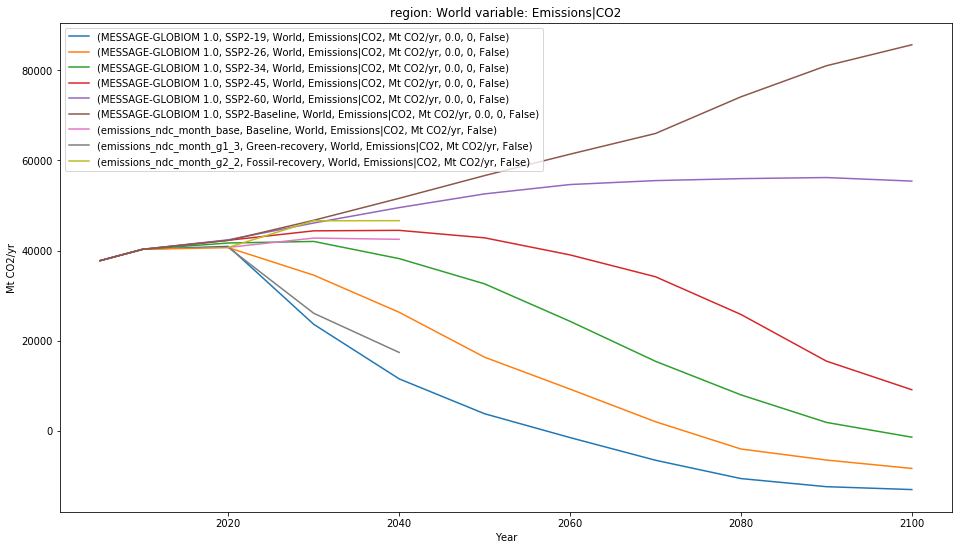

In [25]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
infiller_df.filter(variable=CO2).line_plot(ax=ax)
infilled.filter(variable=CO2).line_plot(ax=ax)

Once again the lines all fall within the expected limits so we can use the linear infiller for this scenario.

In [26]:
green_add = mi.infill_all_required_variables(
    infilled.filter(scenario='Green-recovery', year=2040), infiller_df, [CO2], 
    desired_vars + [lead], 
    dc.LinearInterpolation
)

Filling required variables: 100%|██████████████████████████████████████████████████████| 14/14 [00:01<00:00, 11.56it/s]


In [27]:
green_add.timeseries()

2040
model                    scenario       region variable                                      unit                         
emissions_ndc_month_g1_3 Green-recovery World  Emissions|BC                                  Mt BC/yr             4.604685
                                               Emissions|CH4                                 Mt CH4/yr          239.620166
                                               Emissions|CO                                  Mt CO/yr           646.592253
                                               Emissions|CO2                                 Mt CO2/yr        17390.110564
                                               Emissions|CO2|AFOLU                           Mt CO2/yr         -863.562254
                                               Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        18253.672822
                                               Emissions|F-Gases                             Mt CO2-equiv/yr    936.432071
                                               Emissions|Kyoto Gases (AR4-GWP100)            Mt CO2-equiv/yr  27206.542928
                                               Emissions|N2O                                 kt N2O/yr         9667.694486
                                               Emissions|NH3                                 Mt NH3/yr           46.113276
                                               Emissions|NOx                                 Mt NO2/yr           68.196587
                                               Emissions|OC                                  Mt OC/yr            26.140914
                                               Emissions|Sulfur                              Mt SO2/yr           30.641979
                                               Emissions|VOC                                 Mt VOC/yr          156.485648

In [28]:
output = infilled.append(green_add.filter(variable=CO2, keep=False))

# Formatting output
Everything is in the correct units, we just need to save it to file. 

In [29]:
output.to_csv("../output/covid_response_infilled_AR{}.csv".format(4 if use_ar4_data else 5))